<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=681080 sha256=96be554364c2838b59fe5c87f22d17ce113821c08ff41f7ea3483e57a9a25199
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import gc

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import transformers
from transformers import AdamW

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1 = '/content/drive/My Drive/bert/new_dataset3_big.csv'
df = pd.read_csv(file_path1)

In [ ]:
df.head()

,Text,oh_label
0,`- This is not ``creative``. Those are the di...,0
1,- Important note for all sysops: There is a ...,0
2,`:If you ever claimed in a Judaic studies prog...,0
3,"`Someone wrote: More recognizable, perhaps, is...",0
4,gets far more tendentious yet.,0


In [ ]:
df['oh_label'].value_counts()

0    72549
1    72482
Name: oh_label, dtype: int64

In [ ]:
# 데이터 1 칼럼 불필요 한거 없애기
df.isnull().sum()

Text        0
oh_label    0
dtype: int64

In [ ]:
print(df.isnull())

         Text  oh_label
0       False     False
1       False     False
2       False     False
3       False     False
4       False     False
...       ...       ...
145026  False     False
145027  False     False
145028  False     False
145029  False     False
145030  False     False

[145031 rows x 2 columns]


In [ ]:
import neattext as nt
import neattext.functions as nfx
import re

In [ ]:
from html import unescape
# Preprocess text function
def preprocess_text(text):
    # 1. Find #[xX]?\w+; and put '&' to the first
    text = re.sub(r'(^|\D)#\w+;', lambda match: f'&{match.group()}' if match.group().startswith('#') else f'{match.group()[0]}&{match.group()[1:]}', text)
    # 2. Convert HTML character to unicode
    text = unescape(text)
    # 3. Remove http, https
    text = re.sub(r'http\S+|https\S+', '', text)
    # 4. Remove email
    text = re.sub(r'\S+@\S+', '', text)
    # 5. Remove twitter id
    text = re.sub(r'@\w+', '', text)
    # 6. Remove "&lt;/b&gt;"
    text = re.sub(r'&lt;/b&gt;', '', text)
    # 7. Remove &quot; and quot;
    text = re.sub(r'&quot;|quot;', '', text)
    # 8. Replace &amp; and amp; with &
    text = re.sub(r'&amp;|amp;', '&', text)
    # 9. Replace &lt; and lt; with <
    text = re.sub(r'&lt;|lt;', '<', text)
    # 10. Replace &gt; and gt; with >
    text = re.sub(r'&gt;|gt;', '>', text)
    # 11. Remove the text inside parentheses
    text = re.sub(r'\(.*?\)', '', text)
    # 12. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 13. Remove #
    text = re.sub(r'#[\w]*', '', text)
    # Remove user handles
    text = re.sub(r'@\w+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
df['Text'] = df['Text'].apply(nfx.remove_stopwords)
df.head()

,Text,oh_label
0,`- ``creative``. dictionary definitions terms ...,0
1,- Important note sysops: bug administrative fe...,0
2,`:If claimed Judaic studies program ultra-Orth...,0
3,"`Someone wrote: recognizable, perhaps, type ge...",0
4,gets far tendentious yet.,0


In [ ]:
df1 = df[df['oh_label'] == 1]
df1.head()

,Text,oh_label
17,` :Click ``Annoying Users`` link! guess Massac...,1
19,Iraq good === === USA bad,1
40,` Buddha - ``Some suggest victims referred add...,1
64,____ fuck little asshole. want talk human star...,1
105,"dick, bigger yours! hahaha",1


## Train, Test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")



Training set size: 101521
Validation set size: 21755
Test set size: 21755


In [ ]:
df_train.tail()

,Text,oh_label
101516,== fuck == fuck misterwiki. fuck misterwiki. f...,1
101517,` ::::those ``abbreviations`` hyperlinks links...,0
101518,vandalize Wikipedia Page mistake....He new pla...,0
101519,"second look-through, prose smidge choppy place...",0
101520,`I'm putting concentrating things. going touch...,0


## 로베르타 인풋 만들기


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

MODEL_TYPE = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_TYPE)


In [ ]:
# vocab크기 확인
tokenizer.vocab_size

50265

In [ ]:

list(tokenizer.get_vocab())[:10]

['<s>', '<pad>', '</s>', '<unk>', '.', 'Ġthe', ',', 'Ġto', 'Ġand', 'Ġof']

In [ ]:
!nvidia-smi

Sat Jun 10 15:37:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    56W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# device 설정
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
L_RATE = 1e-5
MAX_LEN = 256

BATCH_SIZE = 32
NUM_CORES = os.cpu_count() # Dataloader

NUM_CORES

12

In [ ]:
# train, val에 사용
class CompDataset(Dataset):

    def __init__(self, df_train):   # 변경된 부분
        self.df = df_train     # 변경된 부분

    def __getitem__(self, index):
        #print("Accessing index: ", index)
        sentence1 = self.df.loc[index, 'Text']

        encoded_dict = tokenizer.encode_plus(
                    sentence1,
                    add_special_tokens = True,
                    max_length = MAX_LEN,
                    #padding = 'max_length'
                    pad_to_max_length = True,
                    truncation=True,
                    return_attention_mask = True,
                    return_tensors = 'pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        # 숫자로 변환된 label을 텐서로 변환
        target = torch.tensor(self.df.loc[index, 'oh_label'])  # 변경된 부분
        # input_ids, attention_mask, label을 하나의 인풋으로 묶음
        sample = (padded_token_list, att_mask, target)

        return sample

    def __len__(self):
        return len(self.df)

# test 예측에 사용
class TestDataset(Dataset):

    def __init__(self, df_test):   # 변경된 부분
        self.df = df_test     # 변경된 부분

    def __getitem__(self, index):

        sentence1 = self.df.loc[index, 'Text']  # 변경된 부분

        encoded_dict = tokenizer.encode_plus(
                    sentence1,
                    add_special_tokens = True,
                    max_length = MAX_LEN,
                    #padding = 'max_length'
                    pad_to_max_length = True,
                    return_attention_mask = True,
                    truncation=True,
                    return_tensors = 'pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        # input_ids, attention_mask를 하나의 인풋으로 묶음
        sample = (padded_token_list, att_mask)

        return sample


    def __len__(self):
        return len(self.df)


In [ ]:
from transformers import RobertaConfig, RobertaForSequenceClassification

# Specify the dropout rate in the configuration
config = RobertaConfig.from_pretrained(
    'roberta-large',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.1,  # dropout rate
    attention_probs_dropout_prob=0.1,  # dropout rate
)

# Use the configuration to initialize the model
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-large',
    config=config,
)

model.to(device)
'''from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-large',  # 모델 이름을 roberta-base로 변경
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    dropout = 0.1, # dropout rate
)

# model을 device위에 올림
model.to(device)'''


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should 

"from transformers import RobertaForSequenceClassification\n\nmodel = RobertaForSequenceClassification.from_pretrained(\n    'roberta-large',  # 모델 이름을 roberta-base로 변경\n    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   \n    output_attentions = False, # Whether the model returns attentions weights.\n    output_hidden_states = False, # Whether the model returns all hidden-states.\n    dropout = 0.1, # dropout rate\n)\n\n# model을 device위에 올림\nmodel.to(device)"

In [ ]:
train_data = CompDataset(df_train)
val_data = CompDataset(df_val)
test_data = TestDataset(df_test)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CORES)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CORES)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

3173
680
680


In [ ]:
len(df)

145031

In [ ]:
from transformers import get_linear_schedule_with_warmup

# 학습 횟수
NUM_EPOCHS=5

loss_values = []
acc_values = []
loss_val = []
acc_val = []


from torch.optim import AdamW
from sklearn.metrics import accuracy_score

optimizer = AdamW(model.parameters(), lr=L_RATE)

# 총 학습 스텝: 배치 개수 * 에폭 수
total_steps = len(train_dataloader) * NUM_EPOCHS

# Learning rate scheduler 설정
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# 학습 시작
for epoch in range(NUM_EPOCHS):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))

    targets_list = []
    preds_list = []

    # ========================================
    #               Training
    # ========================================

    print('Training...')
    # put the model into the training mode
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # clear any previously calculated gradients
        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # get the loss
        loss = outputs.loss

        # add up the train loss
        total_loss += loss.item()

        # perform backpropagation
        loss.backward()

        # update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Calculate training progress percentage
        progress = (step / len(train_dataloader)) * 100
        print('Training Progress: {:.2f}%'.format(progress), end='\r')

        # Store predictions and targets for accuracy calculation
        preds = torch.argmax(outputs.logits, dim=1)
        targets_list.extend(b_labels.cpu().numpy())
        preds_list.extend(preds.cpu().numpy())

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Calculate accuracy
    avg_train_acc = accuracy_score(targets_list, preds_list)

    print("Average train loss: {}".format(avg_train_loss))
    print("Average train accuracy: {}".format(avg_train_acc))

    # Append the average loss and accuracy
    loss_values.append(avg_train_loss)
    acc_values.append(avg_train_acc)

    # ========================================
    #               Validation
    # ========================================
    print("\nValidation...")

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    val_targets_list = []
    val_preds_list = []

    # Evaluate data for one epoch
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # Get the loss and "logits"--the model outputs prior to activation.
        val_loss = outputs.loss
        logits = outputs.logits

        # Accumulate the validation loss.
        total_eval_loss += val_loss.item()

        # Calculate accuracy
        val_preds = torch.argmax(logits, dim=1)
        val_targets_list.extend(b_labels.cpu().numpy())
        val_preds_list.extend(val_preds.cpu().numpy())

    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_val_accuracy = accuracy_score(val_targets_list, val_preds_list)
    print("Average validation loss: {}".format(avg_val_loss))
    print("Average validation Accuracy: {}".format(avg_val_accuracy))

    # Add this validation loss and accuracy to the list for plotting
    loss_val.append(avg_val_loss)
    acc_val.append(avg_val_accuracy)


======== Epoch 1 / 5 ========
Training...
Average train loss: 0.2364814853298032
Average train accuracy: 0.9021384738132997

Validation...
Average validation loss: 0.19873956683475305
Average validation Accuracy: 0.9204780510227534

======== Epoch 2 / 5 ========
Training...
Average train loss: 0.1682715991531313
Average train accuracy: 0.9355798307739286

Validation...
Average validation loss: 0.1804188908653005
Average validation Accuracy: 0.9290737761434154

======== Epoch 3 / 5 ========
Training...
Average train loss: 0.12601835384854582
Average train accuracy: 0.9557332965593326

Validation...
Average validation loss: 0.20004616440342302
Average validation Accuracy: 0.9297173063663525

======== Epoch 4 / 5 ========
Training...
Average train loss: 0.10001911062110606
Average train accuracy: 0.9689128357679692

Validation...
Average validation loss: 0.25777805168387097
Average validation Accuracy: 0.9327510917030568

======== Epoch 5 / 5 ========
Training...
Average train loss: 0.08

In [ ]:
# 모델 저장
model.save_pretrained('/content/drive/My Drive/bert/roberta_ver4_large_new')


In [ ]:
from sklearn.metrics import classification_report

# TestDataset을 df_test로 초기화
test_data = TestDataset(df_test)

# DataLoader를 다시 초기화
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)

model.eval() # 모델 평가 모드로 전환

predictions = [] # 예측 결과를 저장할 리스트 초기화

# 테스트 시작 (XML-RoBERTa)
for j, batch in enumerate(test_dataloader):
    inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))
    print(inference_status, end='\r')

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():  # 기울기 계산 비활성화
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    preds = torch.argmax(logits, dim=1)
    predictions.extend(preds.cpu().numpy()) # 예측 결과를 predictions에 추가

# 실제 레이블
y_true = df_test['oh_label']

# classification_report 출력
print(classification_report(y_true, predictions, digits=3))



              precision    recall  f1-score   support

           0      0.952     0.921     0.937     10998
           1      0.922     0.953     0.937     10757

    accuracy                          0.937     21755
   macro avg      0.937     0.937     0.937     21755
weighted avg      0.937     0.937     0.937     21755



In [ ]:
print(len(y_true))
print(len(predictions))


9261
13


In [ ]:
import numpy as np
import random
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch

MODEL_PATH = '/content/drive/My Drive/bert/roberta_ver4_large_new'
MODEL_TYPE = 'roberta-base'
MAX_LEN = 256


model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = RobertaTokenizer.from_pretrained(MODEL_TYPE)

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def sentence_convert_data(sentence):
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    return input_ids, attention_mask

def predict_single_sentence(sentence):
    input_ids, attention_mask = sentence_convert_data(sentence)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_label = torch.argmax(probabilities).item()

    return "Malicious comment" if predicted_label == 1 else "Non-malicious comment"





In [ ]:
def predict_random_data(df):
    random_index = random.choice(df.index.tolist())
    random_text = df.loc[random_index, 'Text']
    prediction = predict_single_sentence(random_text)
    return random_text, prediction

random_text, prediction = predict_random_data(df)
print("Text:", random_text)
print("Prediction:", prediction)

Text: == message == f uc k hoe b c h want
Prediction: Malicious comment


In [ ]:
predict_single_sentence("fuck")


'Malicious comment'

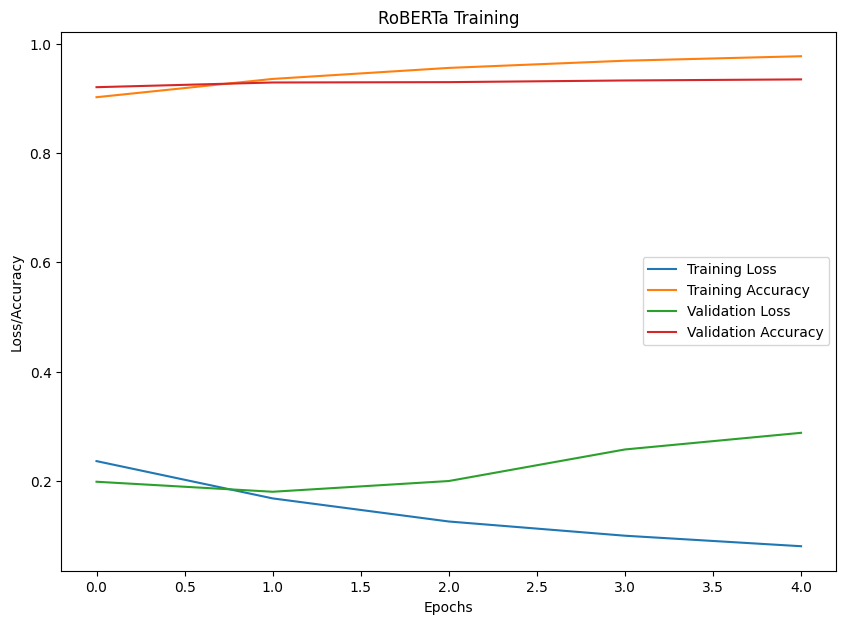

In [ ]:
import matplotlib.pyplot as plt

# 추가한 코드
plt.figure(figsize=(10, 7))
plt.plot(loss_values, label = "Training Loss")
plt.plot(acc_values, label = "Training Accuracy")
plt.plot(loss_val, label="Validation Loss")
plt.plot(acc_val, label ="Validation Accuracy")
# Validation Loss와 Accuracy를 추가하려면 이 값들도 추적하고 저장해야 합니다.

plt.title('RoBERTa Training')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

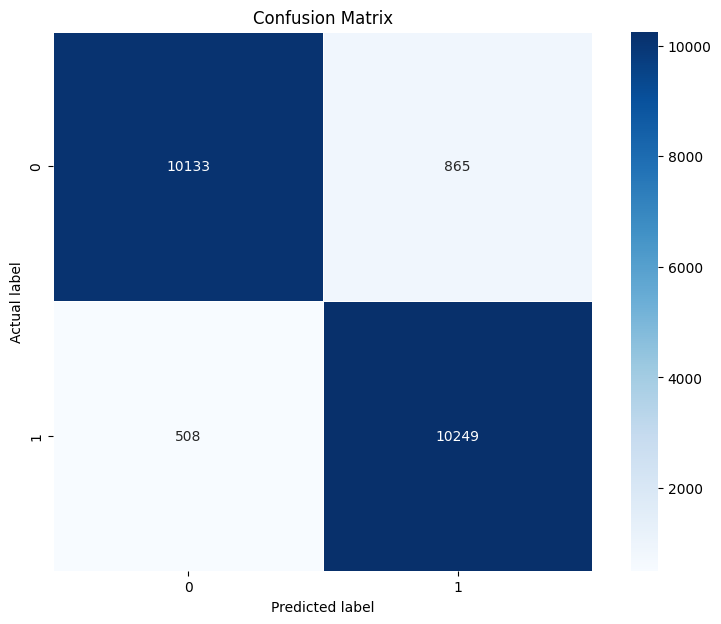

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()